## 12.5 Introduction to Generative Adversarial Networks (GANs)

In [1]:
import os
import sys
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

### What are GANs? An anecdotal introduction

1. An uninspired artist produces some fake Picassos.
2. The fakes are mixed with original Picassos and presented at a fair.
3. An art critic wants to buy real Picassos, and therefore tries to recognise the real ones from the fakes.
4. The forger sees the dealer's choices, uses this feedback to improve the quality of new fakes!
5. The game continues, **ideally both players get ever better at what they do**.

### Game Theory

This is known in game theory as a **Minimax Game**.

The *fakeness* of a painting is just a number, say from zero to one.

Given one fake painting:
- the *artist* wants to **minimise** the critic's accuracy (fool the critic!).
- the *critic* wants to **maximise** its own accuracy (= its ability to triage);

→ **mini-max**

The game is entangled because the *artist* is not the one giving the score, the *critic* is. The *artist* is trying to influence the *critic's* judgment by changing its production.

A GAN network is there fore **two networks in one**, trained together, with:
- a **generator** that takes a random point in the latent space and decodes it into a synthetic image;
- a **discriminator** predicts whether an image came from the training set or from the generator.

The generator is the **artist**, the discriminator is the **critic**.

### Training instability

As the generator tries to fool the discriminator, and the discriminator to detect the fakes, **the system is constantly evolving**.

There is no guarantee that the latent space is structured or even continuous.

A GAN does not have a fixed loss landscape (loss plotted against parameters) – the entire landsape changes with each step.

The aim is not minimisation, but a **(Nash) equilibrium** (where neither player can improve their strategy).

This involves a **lot** of bells and whistles to make it work properly.

---

## 12.5.1 A schematic GAN implementation

<!-- ![Chollet GANs](images/gan/chollet.gans.p.402.png) -->

<img src="https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/gan/chollet.gans.p.402.png?raw=true">


<small>DLWP, p.402</small>

Here, the Generator takes in a latent vector with a chosen dimension, and transforms it into an image.

<!-- ![DCGAN Generator](images/gan/radford.dcgan.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/gan/radford.dcgan.png?raw=true">

Source: [Radford et al, "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks"](https://arxiv.org/abs/1511.06434)

### Architecture

#### The Generator

1. Maps vectors from the latent space to images (*decoding*/*generating*).   
   The vectors are random $n$-dimensional vectors (normal distribution) where $n$ is the dimension of the latent space.
2. A batch of images is created, with both **generated and real ones**, from any dataset (e.g. CelebA, CIFAR10, your own);

#### The Discriminator

3. Processes the batch of images, and outputs a binary score in $[0, 1]$, i.e. a **probability** for each image in the mixed set;

#### Combined training

4. The generator is frozen;
5. The discriminator is trained to **minimise its loss** on generated and real images, i.e. to become better at spotting fakes.
7. Then the discriminator is frozen;
8. The generator is trained to **maximise** the discriminator loss (here: minimise the loss on _misleading labels_), i.e. to produce images **that the discriminator will classify as real**;

#### GANs: The Maths

$$
\bbox[5px,border:2px solid red]
{
\min_G \max_D V(D, G)= \overbrace{Loss(D(x))}^{discriminator} + \overbrace{Loss(1 - D(G(z)))}^{generator}]
}
$$

$V$: "Value function": the whole GAN network  
$G, D$: Generator, Discriminator  
$x, z$: real image, latent space sample

##### Note

The overall loss is formulated so that we can minimise the whole thing during training (as usual).

When $D$ is good, $Loss(D(x))$ is low.  
When $G$ is good, $Loss(1 - D(G(z)))$ is low ($D$ has been fooled, gives a 1 to a fake image).

#### GAN: The Full Math

In the paper, you also take into account the expected value over many samples:

$$
\min_G \max_D V(D, G)= \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log(1 - D(G(z)))]
$$

You can read this in the following way (if $D$ wins, the loss is zero, whereas if $G$ wins, it goes to $-\infty$):

$$
\min _{G}\max _{D}V(D, G) =  \mathbb {E} _{x\sim p _{data}(x)  } [\overbrace{  \ln \overbrace{  D(x) }^{  D\ correct\rightarrow 1 }  }^{  \ln(1) \rightarrow 0  } ] + \mathbb {E} _{z\sim p _{z}(z) } [\underbrace{  \ln(1 -  \underbrace{  D( \underbrace{  G(z) }_{  G \rightarrow fake }) }_{  D\ fooled \rightarrow 1,\ correct \rightarrow 0 } ) }_{  \ln(1 - 1) = \ln(0) \rightarrow -\infty,\ \ln(1 - 0) = \ln(1) \rightarrow 0 }]
$$

$V$: "Value function": the whole GAN network  
$G, D$: Generator, Discriminator  
$x, z$: real image, latent space sample  
$\mathbb{E}_{x\sim p_{data}(x)}$: sampling from our (real) dataset   
$\mathbb{E}_{z\sim p_z(z)}$: sampling from the (fake) latent space

[Goodfellow et al. "Generative Adversarial Networks"](https://arxiv.org/abs/1406.2661)

GANs, despite being difficult to train and not giving us easy access to their implicit latent space, were the first class of models to generate very high quality images, ushering a new era in the arts. Below is the first AI picture to be sold in an art auction (the team who built the system decided to sign the 'painting' with the minimax 

<!-- <img style="height:750px" src="images/gan/GAN.Edmond_de_Belamy.png"> -->
<img style="height:750px" src="https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/gan/GAN.Edmond_de_Belamy.png?raw=true">

<small>[Obvious, *Edmond de Belamy*, 2016](https://en.wikipedia.org/wiki/Edmond_de_Belamy)</small>

---

## 12.5.2 A bag of tricks

- Sample from the latent space using a **normal distribution** (Gaussian), not a uniform one;
- GANs are likely to get stuck in all sorts of ways (it's an unstable, dynamic equilibrium):  
  we introduce **random noise** to the labels for the discriminator to prevent this;
- Sparse gradients can hinder GAN training, remedy: **strided convolutions** for downsampling instead of max pooling, and the [**`LeakyReLU`**](https://paperswithcode.com/method/leaky-relu) instead of `ReLu`;
- To avoid checkerboard artifacts caused by unequal coverage of the pixel space in the generator, use a kernel size **divisible by the stride size** with strided `Conv2DTranspose` or `Conv2D`. Some implementations get rid of the transposed convolutions altogether, and use [`UpSampling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) followed by convolutions (see [here](https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/)).

<small>DLWP, p.404</small>

---

## 12.5.3 Getting our hands on the CelebA dataset

### Getting the CelebA data


#### In Colab


Workflow recommendation: on Colab, it is much faster to download a zip of a dataset (even one you host on your Google drive, if you then click on the three dots, share, and choose to share it with "anyone with the link", the link you get when you copy it contains the ID used above!). If you want to work with a custom dataset, I recommend that you upload a zip file to your Drive (or some other place allowing downloads, e.g. Amazon S3), and download the dataset every time you do a run.


#### Locally


Download manually [here](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and unzip. (I chose the aligned version.)  


In [3]:
if "google.colab" in sys.modules:
    print("Running in Colab")
    !mkdir celeba_gan
    !gdown 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
    !unzip -qq celeba_gan/data.zip -d celeba_gan # will unzip to celeba_gan

Running in Colab
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=7f16653c-a9de-462f-a412-95890ccd2825
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:55<00:00, 25.9MB/s]


### Creating a dataset from a directory of images

In [5]:
DATASET_DIR = pathlib.Path("celeba_gan")  # this will fail if you don't have a `celeba_gan` dir
IMG_DIR = DATASET_DIR / "img_align_celeba" # with, inside it, another one with the same name containing the images

RESULTS_DIR = DATASET_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

BATCH_SIZE = 32 # 128
IMG_SIZE = 64

dataset = tf.keras.utils.image_dataset_from_directory(
    IMG_DIR,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 202599 files.


**Rescaling the images**

In [6]:
dataset = dataset.map(lambda x: x / 255.)

**Displaying the first image**

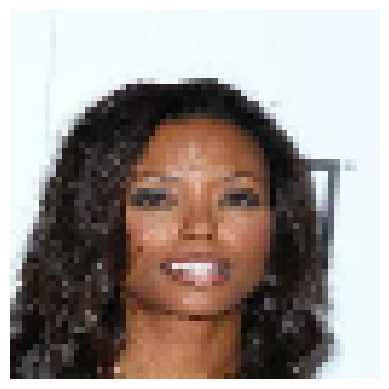

In [7]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

---

## 12.5.4 The discriminator

In [8]:
def build_discriminator():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(negative_slope=0.2), # new argument name
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(negative_slope=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(negative_slope=0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
discriminator = build_discriminator()

In [9]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

---

## 12.5.5 The generator

In [11]:
def build_generator(latent_dim = 128):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 128),
            tf.keras.layers.Reshape((8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(negative_slope=0.2),
            tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(negative_slope=0.2),
            tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(negative_slope=0.2),
            tf.keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        ],
        name="generator",
    )

generator = build_generator()

In [12]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

#### Note: Transposed convolutions

[`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) docs, like with VAEs. See also [this article](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d), and especially [that paper](https://arxiv.org/abs/1603.07285) ([github](https://github.com/vdumoulin/conv_arithmetic)).

<!-- ![Kaveh, stack overflow](images/deconv/deconv.1.png) -->
![Kaveh, stack overflow](https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/deconv/deconv.1.png?raw=true)

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

<!-- ![Kaveh, stack overflow](images/deconv/deconv.2.png) -->
![Kaveh, stack overflow](https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/deconv/deconv.2.png?raw=true)


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

---

## 12.5.6 The adversarial network

### Full GAN model and training logic

In [13]:
class GAN(tf.keras.Model):                                                  # subclassing `tf.keras.Model`
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")           # custom metrics
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):                   # `compile` required for `tf.keras.Model`
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):                                       # `train_step` required for `tf.keras.Model`
        batch_size = tf.shape(real_images)[0]

        # 1. TRAIN DISCRIMINATOR --------------------------------------------------
        # In this compact implementation, we create an array of fake/generated and 
        # real images, and an equivalent array of labels (fake: 1, real: 0), add
        # some noise, and use that to train the discriminator

        random_latent_vectors = tf.random.normal(                            # feed a batch of generated
            shape=(batch_size, self.latent_dim)
        )
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0) # & real images
        labels = tf.concat( # (fake: 1, real: 0)
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        ) # (↓ label smoothing: inject randomness in the labels)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:                                      # gradient logic:
            predictions = self.discriminator(combined_images)                # Discriminator predicts
            d_loss = self.loss_fn(labels, predictions)                       # BCE loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # gradients to update
        self.d_optimizer.apply_gradients(                                    # our Discriminator
            zip(grads, self.discriminator.trainable_weights)
        )
        self.d_loss_metric.update_state(d_loss) # update loss

        # 2. TRAIN GENERATOR ------------------------------------------------------
        # then we generate more fake images (some implementations reuse the same
        # generated images as above), and this time we use the same process of 
        # prediction by the discriminator to train the generator

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        misleading_labels = tf.zeros((batch_size, 1)) # 0: real!

        with tf.GradientTape() as tape:                                 # gradient logic:
            predictions = self.discriminator(                           # get predictions from Discriminator
                self.generator(random_latent_vectors)                   # from generated fake images
            )
            g_loss = self.loss_fn(misleading_labels, predictions)       # BCE loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights) # gradients to update
        self.g_optimizer.apply_gradients(                               # our Generator
            zip(grads, self.generator.trainable_weights)
        )
        self.g_loss_metric.update_state(g_loss) # update loss

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }

### A callback that samples generated images during training

In [14]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, show_every=1, save=True):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save = save
        self.show_every = show_every

    def on_epoch_end(self, epoch, logs=None):

        # create a batch of latent vectors
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # pass those to generate images
        generated_images = self.model.generator(random_latent_vectors)
        # denormalise and convert to NumPy
        generated_images *= 255
        generated_images.numpy()

        if self.save:
            for i in range(self.num_img):
                img = tf.keras.utils.array_to_img(generated_images[i])
                img.save(RESULTS_DIR / f"generated_img_{epoch:03d}_{i}.png")

        if epoch % self.show_every != 0:
            return

        _, axs = plt.subplots(2,2, figsize=(12,12)) # https://stackoverflow.com/a/54681765
        axs = axs.flatten()
        for i, (img, ax) in enumerate(zip(generated_images, axs)):
            img = tf.image.resize(img, (1024,1024)) # here I artificially scale up the generated pictures!
            img = tf.keras.utils.array_to_img(img)
            ax.axis('off')
            ax.imshow(img)
        plt.show()



### Compilation

In [15]:
EPOCHS = 100
LATENT_DIM = 128

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # very small learning rates!
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

### Reloading a trained model (to continue training)

You can download the model I trained [here](https://drive.google.com/file/d/11qiqka33s_Wmo-XdNVlQW1EdkYnWYlhx/view?usp=sharing), for instance using `gdown` (no install needed on Colab):

```bash
!gdown [file id in url]
!unzip celeba-gan.models.zip
```

This will unzip the model to `models`, which works with the present code.

In [16]:
RELOAD = False # True to reload

MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(exist_ok=True)

GENERATOR_PATH = MODELS_DIR / "generator_celeba_gan.weights.h5" # must end in .weights.h5
DISCRIMINATOR_PATH = MODELS_DIR / "discriminator_celeba_gan.weights.h5"

if RELOAD and DISCRIMINATOR_PATH.is_file() and GENERATOR_PATH.is_file():
    gan.generator.load_weights(GENERATOR_PATH)
    gan.discriminator.load_weights(DISCRIMINATOR_PATH)

### Training

**Note**

If during training you see that all your images look the same, this is a case of [mode collapse](https://pub.towardsai.net/gan-mode-collapse-explanation-fa5f9124ee73), where your generator focusses only one one _type of image_ (= one _mode_ of the image distribution), and jumps from mode to mode to evade the discriminator. I don't know of a way to escape this failure mode except by restarting everything from scratch (reinitialising the model weights, retraining)... That's one of the difficulties/instabilities in GAN training!

Epoch 1/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.5283 - g_loss: 1.6357

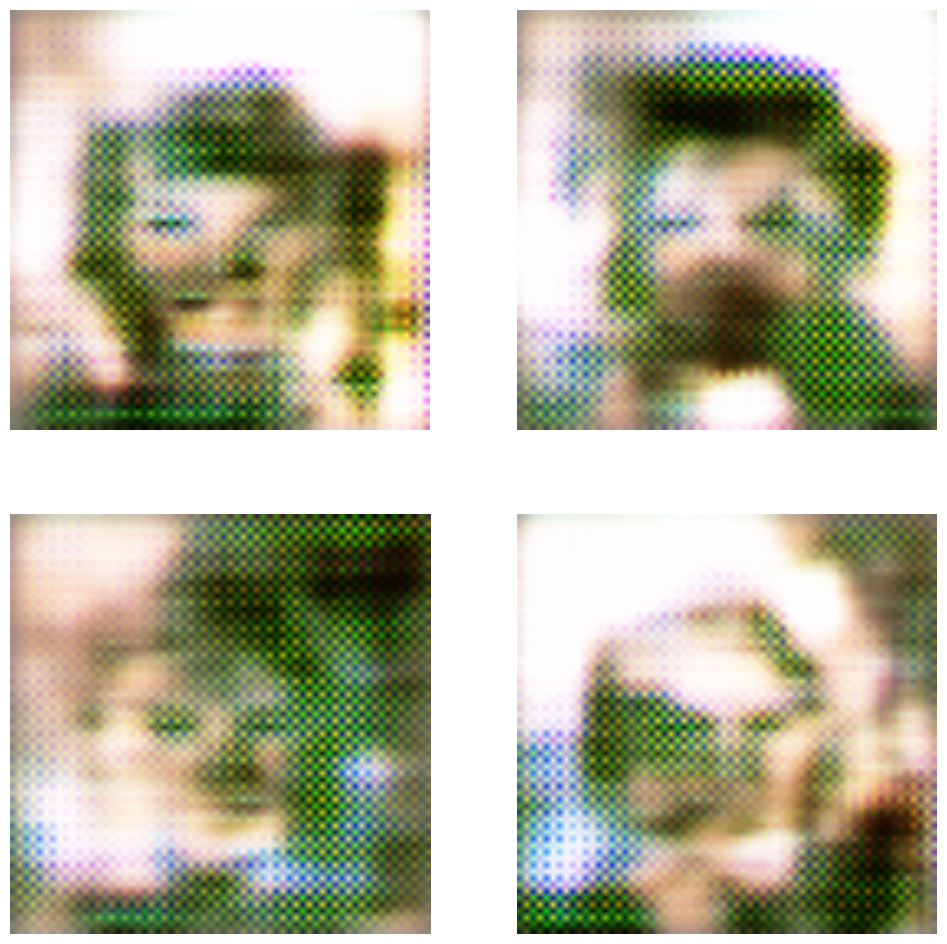

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - d_loss: 0.5283 - g_loss: 1.6356
Epoch 2/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6602 - g_loss: 1.0494
Epoch 3/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6671 - g_loss: 0.9907
Epoch 4/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6694 - g_loss: 0.9911
Epoch 5/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6265 - g_loss: 1.1093
Epoch 6/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6421 - g_loss: 1.0210
Epoch 7/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6541 - g_loss: 0.9745
Epoch 8/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6636 - g_loss: 0.9323
Epoch 9/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6699 - g_loss: 0.9271
Epoch 10/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6678 - g_loss: 0.9304
Epoch 11/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6740 - g_loss: 0.927

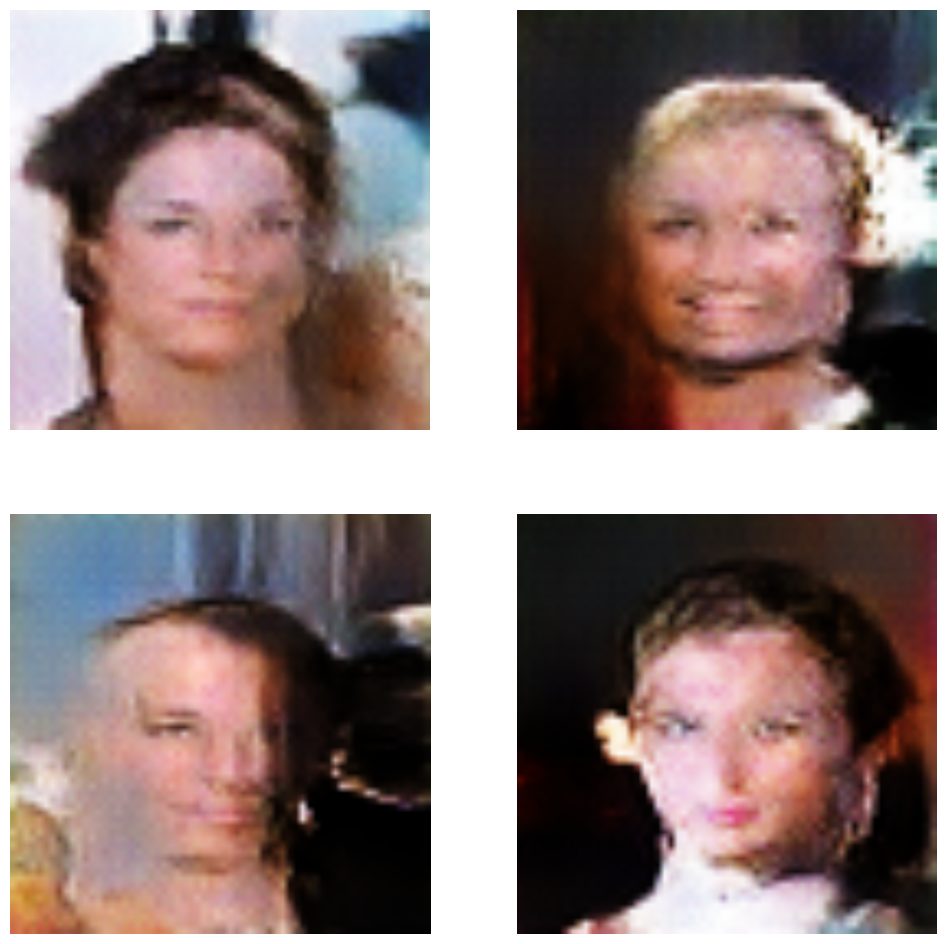

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6508 - g_loss: 0.9325
Epoch 27/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 138s 22ms/step - d_loss: 0.6495 - g_loss: 0.9295
Epoch 28/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 138s 22ms/step - d_loss: 0.6469 - g_loss: 0.9309
Epoch 29/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 137s 22ms/step - d_loss: 0.6417 - g_loss: 0.9541
Epoch 30/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 137s 22ms/step - d_loss: 0.6364 - g_loss: 0.9470
Epoch 31/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6373 - g_loss: 0.9489
Epoch 32/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - d_loss: 0.6367 - g_loss: 0.9450
Epoch 33/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - d_loss: 0.6331 - g_loss: 0.9607
Epoch 34/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6292 - g_loss: 0.9702
Epoch 35/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 134s 21ms/step - d_loss: 0.6249 - g_loss: 0.9718
Epoch 36/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 134s 21ms/step - d_loss: 0.6291 - g_los

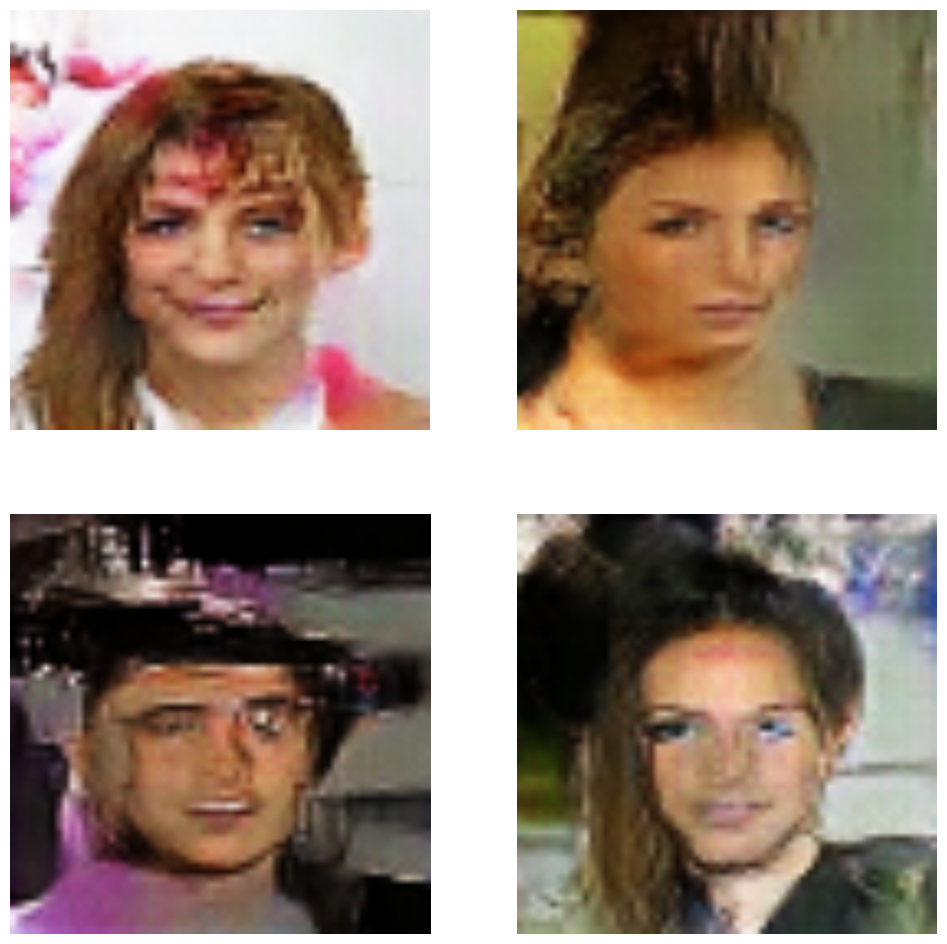

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 138s 22ms/step - d_loss: 0.6096 - g_loss: 1.0246
Epoch 52/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 22ms/step - d_loss: 0.6100 - g_loss: 1.0319
Epoch 53/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 137s 22ms/step - d_loss: 0.6093 - g_loss: 1.0250
Epoch 54/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 22ms/step - d_loss: 0.6078 - g_loss: 1.0421
Epoch 55/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 22ms/step - d_loss: 0.6076 - g_loss: 1.0462
Epoch 56/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - d_loss: 0.6070 - g_loss: 1.0348
Epoch 57/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - d_loss: 0.6066 - g_loss: 1.0426
Epoch 58/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.6011 - g_loss: 1.0567
Epoch 59/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - d_loss: 0.6029 - g_loss: 1.0524
Epoch 60/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - d_loss: 0.6003 - g_loss: 1.0472
Epoch 61/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - d_loss: 0.5989 - g_los

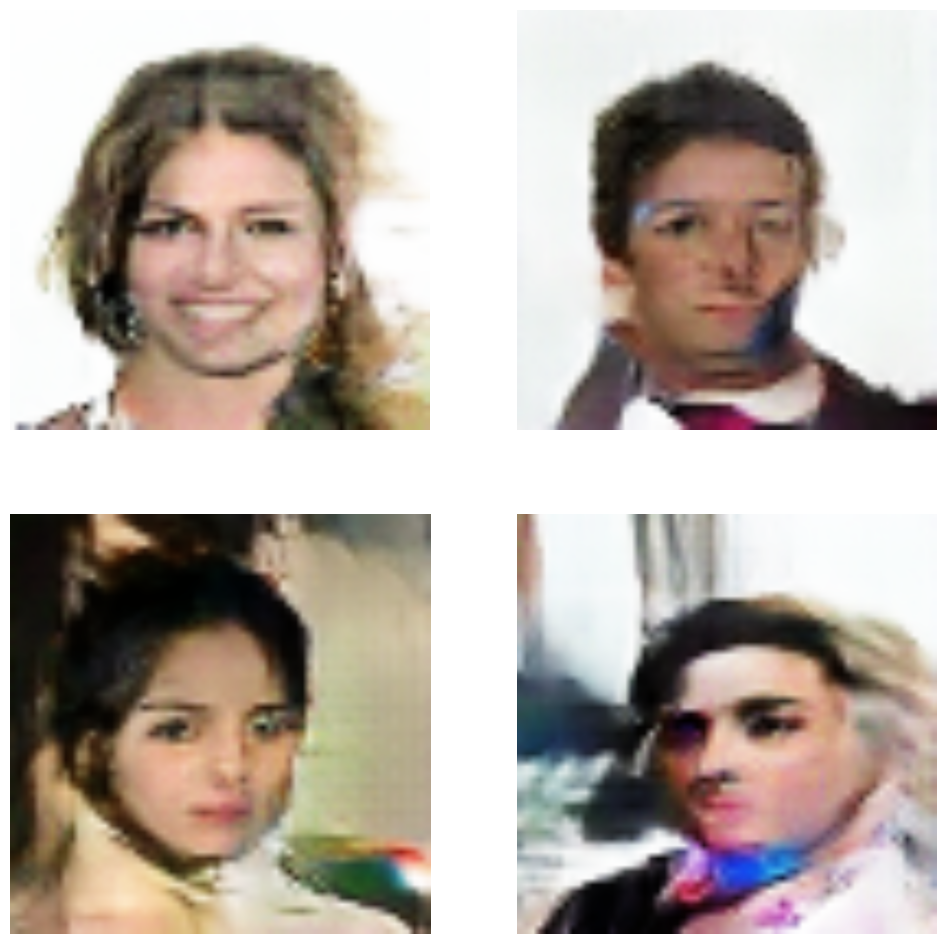

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 141s 22ms/step - d_loss: 0.5762 - g_loss: 1.1218
Epoch 77/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5753 - g_loss: 1.1309
Epoch 78/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5742 - g_loss: 1.1312
Epoch 79/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5744 - g_loss: 1.1412
Epoch 80/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5694 - g_loss: 1.1470
Epoch 81/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5674 - g_loss: 1.1538
Epoch 82/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5680 - g_loss: 1.1601
Epoch 83/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5641 - g_loss: 1.1610
Epoch 84/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.5642 - g_loss: 1.1704
Epoch 85/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.5613 - g_loss: 1.1744
Epoch 86/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.5621 - g_los

In [17]:
gan.fit(
    dataset, epochs=EPOCHS, callbacks=[
        GANMonitor(num_img=4, latent_dim=LATENT_DIM, show_every=25, save=True),
    ],
    # steps_per_epoch=1000 # uncomment this to shorten the epochs / see images more often!
)

### Using the trained model

Note: this creates a grid of images using `plt`, but nothing prevents you to generate just _one_ latent vector, pass it through the generator, and display or save it using `PIL`!

In [18]:
def plot_gan_images(gan):
    n = 12

    # create a batch of latent vectors
    random_latent_vectors = tf.random.normal(shape=(n, LATENT_DIM))
    # pass them through the generator to create images
    generated_images = gan.generator(random_latent_vectors, training = False)
    # denormalize and cast to int
    generated_images = tf.cast(generated_images * 255, tf.uint8)

    # https://stackoverflow.com/a/54681765
    _, axs = plt.subplots(3, 4, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(generated_images, axs):
        ax.axis('off')
        ax.imshow(img.numpy())
    plt.show()

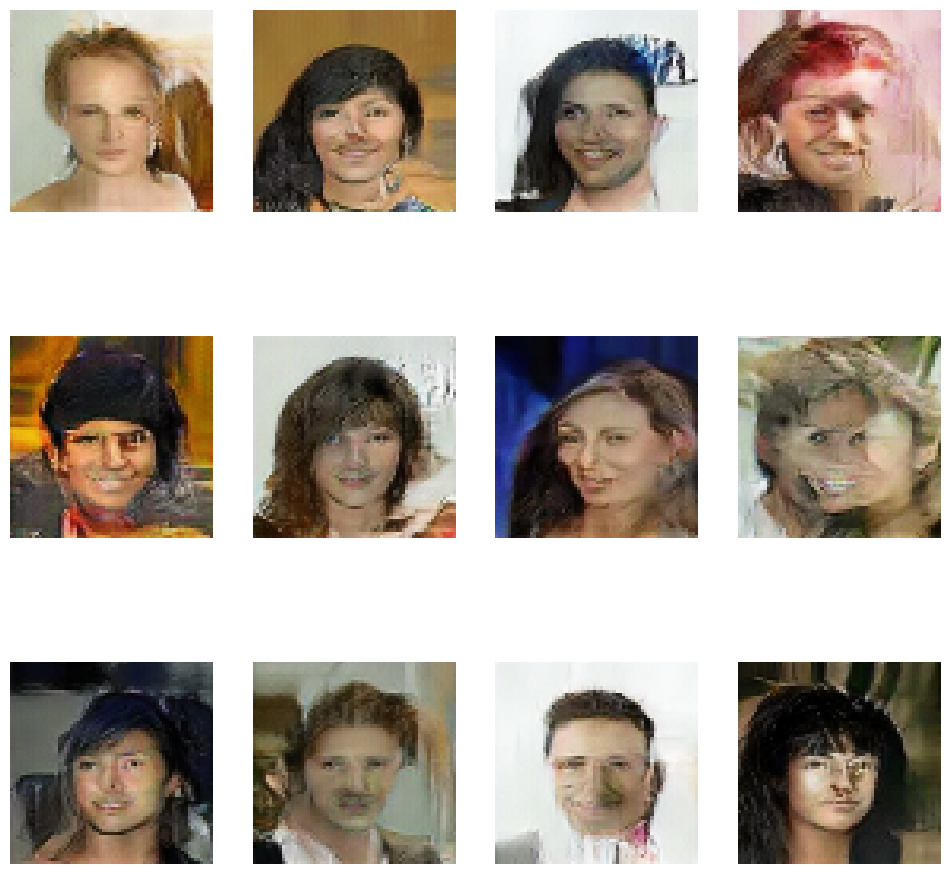

In [19]:
plot_gan_images(gan)

### Save and reload a model

In [20]:
discriminator.save_weights(DISCRIMINATOR_PATH)          # SAVE
generator.save_weights(GENERATOR_PATH)

In [21]:
discriminator_reloaded = build_discriminator()          # REBUILD D & G
generator_reloaded = build_generator()

discriminator_reloaded.load_weights(DISCRIMINATOR_PATH) # LOAD WEIGHTS
generator_reloaded.load_weights(GENERATOR_PATH)

gan_reloaded = GAN(                                     # REBUILD GAN
    discriminator=discriminator_reloaded,
    generator=generator_reloaded,
    latent_dim=LATENT_DIM
)

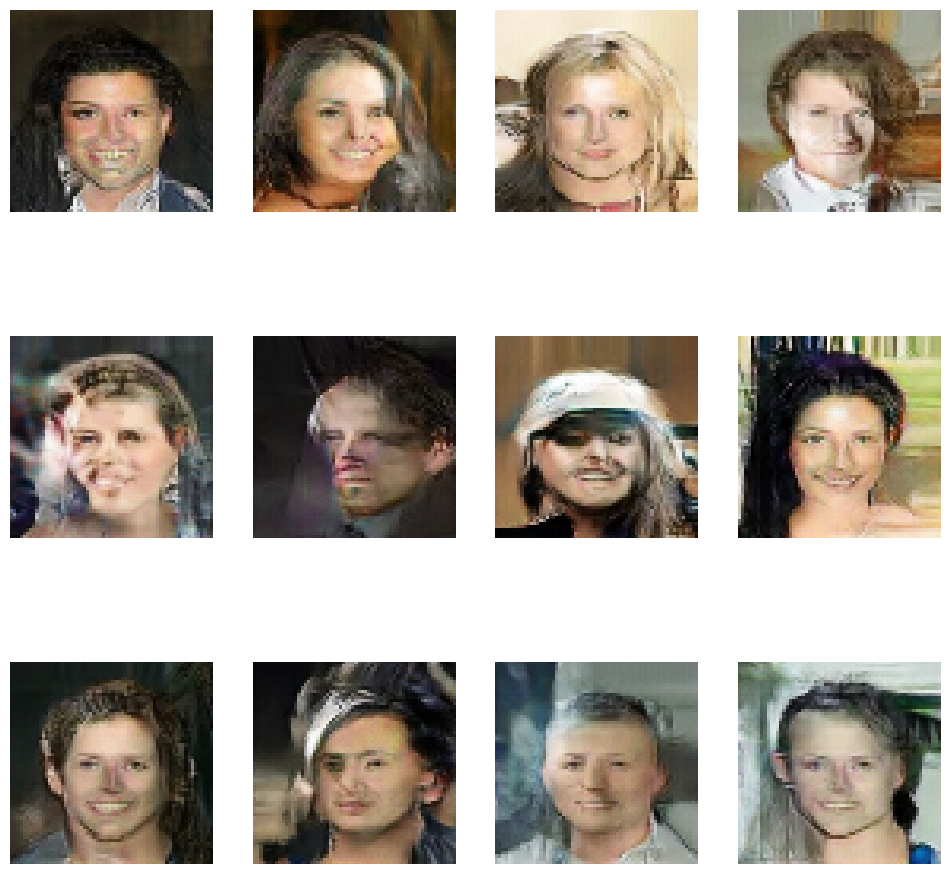

In [22]:
plot_gan_images(gan_reloaded)

### Save models to Google Drive


In [ ]:
EXPORT=False

if EXPORT:
    # zip models
    !zip celeba-gan.models.zip {MODELS_DIR}/*
    # connect to drive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy zip to drive (adjust folder as needed)
    !cp celeba-gan.models.zip drive/MyDrive/IS53024B-Artificial-Intelligence/models

### Nvidia's StyleGan 2 & 3

<!-- <img src="images/gan/stylegan2-teaser-1024x256.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/gan/stylegan2-teaser-1024x256.png?raw=true">

<small>[Nvidia's StyleGAN 2, 2019](https://github.com/NVlabs/stylegan2)   
[Karras et al., "Analyzing and Improving the Image Quality of StyleGAN"](https://arxiv.org/abs/1912.04958)  
And [StyleGAN 3, 2021](https://github.com/NVlabs/stylegan3)  
[Karras et al, "Alias-Free Generative Adversarial Networks"](https://nvlabs.github.io/stylegan3/)
</small>

---

### Experiments

- The main experiment here would be to test results on other datasets;
- After that, it could be interesting to try and change the architecture (e.g. testing less/more layers): this is where you will notice the instability of training, with one of the two losses exploding and the other one going to zero! Finding another good balance (with a different architecture for G and D) is a non-trivial task! If you are interested in this, I would recommend adding a callback that plots your metrics over time, it's easier to spot signs of instability early on and stop training.
- It is possible to create videos of the evolution of the trainig process like so:
  - Instead of generating new latent vectors `z` each time you plot, create a batch of those before starting training, and always use those each time you plot: the images should be almost the same each time, with the quality (hopefully) improving
  - If you save all those in a folder, you can then merge them into a GIF or video!
- Even if the latent space is opaque, it is still possible to do [interpolation between two vectors](https://github.com/soumith/dcgan.torch/issues/14#issuecomment-525160139) and see the results! That's how most GAN art videos are made.
- Cool applications have been developed using variant GAN architectures, worth a try: [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix) and [CycleGAN](https://www.tensorflow.org/tutorials/generative/pix2pix).

---

### 12.5.7 Wrapping up

- A GAN is made of **two parts**:
    - a **generator** network coupled to  
    - a **discriminator** network;  
- The discriminator
    - reads batches of real and fake data;
    - **classifies images** (real or not);
- The generator
    - **never sees real images**;  
    - only knows **if it fools the discriminator**;  

### Training

- GANs are difficult to train because they lack a static loss landscape;  
- Many tricks are needed, and a lot of training;
- GANs can nevertheless generate **highly realistic images**;  
- However, the **latent space is almost certainly unstructured**;  
- We can not **access concept vectors**, or do any controlled manipulation like with VAEs.

## Generative Deep Learning Summary

- Text generation
- DeepDream
- Neural style transfer
- Variational autoencoders
- Generative adversarial networks